# Replicating a Simple GNN on Cora

**Goal**: Train a two-layer Graph Convolutional Network for node classification on the Cora ciitation network, then evaluate accuracy and macro-F1.

**What we'll learn**:
- What a *graph* is in ML terms (nodes, edges, features, labels)
- What a *GCN layer* does
- How to train, validate, and test a node classifier on a graph 

We import PyTorch (deep learning), PyTorch Geometric (graph tools), and sklearn (metrics).

In [56]:
import os, random, time, math, pathlib
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv

from sklearn.metrics import f1_score
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass

## 1. Set seeds

Deep learning uses randomness (weigh initialization, shuffling). Fixing seeds makes runs more repeatable. `DEVICE` selects GPU if available; otherwise CPU.

In [10]:
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seeds(42)

DEVICE

device(type='cpu')

## 2. Load Cora & peek at the data

**What is this dataset?**
- Nodes = research papers
- Edges = citation links (who cites whom)
- Features = bag-of-words descriptions of each paper
- Label = topic category of each paper

We learn a function $$f_\theta(X,A) \to \hat{Y}$$ that uses node features $X$ and graph structure $A$ (adjacency) to predict the **class** $Y$ for each node.

In [26]:
# Dataset root
root = str((pathlib.Path.cwd().parent if pathlib.Path.cwd().name=="notebooks" else pathlib.Path.cwd()) / "data")

dataset = Planetoid(root=root, name="Cora")
data = dataset[0].to(DEVICE)

print(dataset)
print(f"Nodes: {data.num_nodes}")
print(f"Edges (undirected): {data.num_edges//2}")
print(f"Node features (dim): {dataset.num_node_features}")
print(f"Num classes: {dataset.num_classes}")
print("Split sizes (train/val/test):",
        int(data.train_mask.sum()),
        int(data.val_mask.sum()),
        int(data.test_mask.sum()))


Cora()
Nodes: 2708
Edges (undirected): 5278
Node features (dim): 1433
Num classes: 7
Split sizes (train/val/test): 140 500 1000


Graph data structures

`data.x` $\in \mathbb{R}^{n\times d}$: node feature matrix (n=nodes, d=features)

In [36]:
print(data.x[0])
print(data.x.shape)

tensor([0., 0., 0.,  ..., 0., 0., 0.])
torch.Size([2708, 1433])


`data.y` $\in \{0,\dots,C-1\}^n$: node labels (C classes)

In [33]:
print(data.y[0])
print(data.y.shape)

tensor(3)
torch.Size([2708])


`data.edge_index` $\in \mathbb{N}^{2\times m}$: coordiante list edges, each column is an edge (source -> target)

In [47]:
print(data.edge_index[:, 0]) # first column
print(data.edge_index.shape) # 2 rows, 10556 columns

tensor([633,   0])
torch.Size([2, 10556])


`train_mask`, `val_mask`, `test_mask` are boolean vectors of length $n$.

In [42]:
print(data.train_mask.shape)

torch.Size([2708])


## 3. Define a minimal GCN model

**What does a GCN layer do?**

For each node, it:
1. Collects (averages) the representations of its neighbors (including itself),
2. Transforms that average using learable weights,
3. Applies a nonlinearity (ReLU)

**1 Layer Example**:
$$
H^{(l+1)}=\sigma\big(\hat{D}^{-\frac{1}{2}}\hat{A}\hat{D}^{-\frac{1}{2}}\, H^{(l)}W^{(l)}\big)
$$
where $\hat{A}=A+I$ adds self-loops, $\hat{D}$ is degree matrix, $H^{(0)}=X$ (features). This is a special case of message passing on graphs.

In [12]:
class GCN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.5, num_layers=2):
        super().__init__()
        assert num_layers in [2,3], "For this trial, keep it 2 or 3 layers."
        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(in_dim, hidden_dim))
        if num_layers == 3:
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
        self.convs.append(GCNConv(hidden_dim, out_dim))
        self.dropout = dropout

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)  # message passing + linear transform
            if i < len(self.convs) -1: # not on the last layer
                x = F.relu(x)
                x = F.dropout(x, p = self.dropout, training=self.training)
        return x # logits (one score per class)

## 4. Training utilities (early stopping on val)

We pick the epoch with the **best validation accuracy** to avoid overfitting. Then we evaluate once on the held-out test set.

In [13]:
@dataclass
class TrainCfg:
    hidden_dim: int = 64
    lr: float = 0.01
    weight_decay: float = 5e-4
    dropout: float = 0.5
    num_layers: int = 2
    max_epochs: int = 500
    patience: int = 50 # stop if val accuracy doesn't improve

In [14]:
def accuracy_from_logits(logits, y, mask):
    pred = logits.argmax(dim=-1)
    return (pred[mask]==y[mask]).float().mean().item()

In [53]:
def train_one(cfg: TrainCfg, data):
    set_seeds(42)
    model = GCN(
        in_dim = data.num_node_features,
        hidden_dim = cfg.hidden_dim,
        out_dim = int(data.y.max().item()) + 1,
        dropout=cfg.dropout,
        num_layers = cfg.num_layers
    ).to(DEVICE)

    opt = torch.optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

    best_val = -1.0
    best_state = None
    bad_epochs = 0
    history = {"epoch": [], "loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(1, cfg.max_epochs + 1):
        model.train()
        opt.zero_grad()
        logits = model(data.x, data.edge_index)
        loss = F.cross_entropy(logits[data.train_mask], data.y[data.train_mask])
        loss.backward()
        opt.step()

        model.eval()
        with torch.no_grad():
            logits = model(data.x, data.edge_index)
            train_acc = accuracy_from_logits(logits, data.y, data.train_mask)
            val_acc = accuracy_from_logits(logits, data.y, data.val_mask)

        history["epoch"].append(epoch)
        history["loss"].append(float(loss.item()))
        history["train_acc"].append(float(train_acc))
        history["val_acc"].append(float(val_acc))
        
        if val_acc > best_val:
            best_val = val_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad_epochs = 0
        else:
            bad_epochs += 1

        if epoch % 25 ==0 or epoch == 1:
            print(f"epoch {epoch:3d} | loss {loss.item():.4f} | train {train_acc:.3f} | val {val_acc:.3f}")

        if bad_epochs >= cfg.patience:
            # early stopping
            break
        
    # load best checkpoint
    if best_state is not None:
        model.load_state_dict({k: v.to(DEVICE) for k, v in best_state.items()})

    return model, best_val, history

## 5. Train baseline GCN

In [55]:
cfg = TrainCfg()
model, best_val, history = train_one(cfg, data)
best_val

epoch   1 | loss 1.9582 | train 0.836 | val 0.466
epoch  25 | loss 0.0104 | train 1.000 | val 0.784
epoch  50 | loss 0.0104 | train 1.000 | val 0.778
epoch  75 | loss 0.0150 | train 1.000 | val 0.778
epoch 100 | loss 0.0137 | train 1.000 | val 0.774


0.7919999957084656

The printed value is our best validation accuracy. We only use this to select the model. Next we'll test it once.

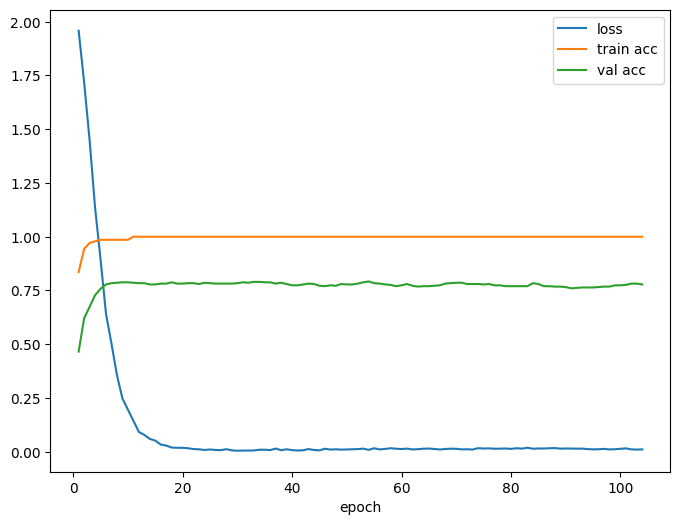

In [58]:
plt.figure(figsize = (8,6))
plt.plot(history["epoch"], history["loss"], label="loss")
plt.plot(history["epoch"], history["train_acc"], label="train acc")
plt.plot(history["epoch"], history["val_acc"], label="val acc")
plt.plot()
plt.xlabel("epoch")
plt.legend()
plt.show()

## 6. Evaluate on the test split (accuracy + macro f1)

Why macro-f1 as well as accuracy?

If classes are imbalanced, accuracy can be misleading. Macro f1 averages F1 over classes equally, giving minority classes fair weight.

In [17]:
def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        logits = model(data.x, data.edge_index)
        yhat = logits.argmax(dim=-1).cpu().numpy()
        y = data.y.cpu().numpy()
        test = data.test_mask.cpu().numpy().astype(bool)
        acc = (yhat[test] == y[test]).mean()
        macro = f1_score(y[test], yhat[test], average = "macro")
    return {"test_acc": acc, "test_macro_f1": macro}

In [18]:
metrics = evaluate(model, data)
metrics

{'test_acc': np.float64(0.809), 'test_macro_f1': 0.7980508036746983}

## 7. Hidden size, layers, dropout

In [19]:
rows = []
for hidden in [16, 64, 128]:
    for layers in [2, 3]:
        for drop in [0.0, 0.5]:
            cfg = TrainCfg(hidden_dim = hidden, num_layers = layers, dropout=drop)
            model, best_val=train_one(cfg, data)
            m = evaluate(model, data)
            rows.append({
                "hidden": hidden,
                "layers": layers,
                "dropout": drop,
                "best_val_acc": best_val,
                "test_acc": m["test_acc"],
                "test_macro_f1": m["test_macro_f1"],
            })
            print(rows[-1])

epoch   1 | loss 1.9444 | train 0.571 | val 0.366
epoch  25 | loss 0.0701 | train 1.000 | val 0.764
epoch  50 | loss 0.0154 | train 1.000 | val 0.778
epoch  75 | loss 0.0176 | train 1.000 | val 0.784
epoch 100 | loss 0.0165 | train 1.000 | val 0.778
{'hidden': 16, 'layers': 2, 'dropout': 0.0, 'best_val_acc': 0.7839999794960022, 'test_acc': np.float64(0.803), 'test_macro_f1': 0.7975079547315848}
epoch   1 | loss 1.9524 | train 0.514 | val 0.354
epoch  25 | loss 0.1844 | train 1.000 | val 0.780
epoch  50 | loss 0.0433 | train 1.000 | val 0.766
epoch  75 | loss 0.0368 | train 1.000 | val 0.768
epoch 100 | loss 0.0427 | train 1.000 | val 0.776
{'hidden': 16, 'layers': 2, 'dropout': 0.5, 'best_val_acc': 0.7839999794960022, 'test_acc': np.float64(0.806), 'test_macro_f1': 0.7989440094679472}
epoch   1 | loss 1.9459 | train 0.364 | val 0.252
epoch  25 | loss 0.0328 | train 1.000 | val 0.770
epoch  50 | loss 0.0043 | train 1.000 | val 0.768
{'hidden': 16, 'layers': 3, 'dropout': 0.0, 'best_val_

In [20]:
ablation_df = pd.DataFrame(rows).sort_values("test_acc", ascending=False).reset_index(drop=True)
ablation_df

,hidden,layers,dropout,best_val_acc,test_acc,test_macro_f1
0,64,3,0.0,0.808,0.816,0.806795
1,64,2,0.0,0.800,0.813,0.804525
2,64,3,0.5,0.800,0.812,0.804820
3,128,3,0.5,0.798,0.811,0.806706
4,64,2,0.5,0.792,0.809,0.798051
5,16,2,0.5,0.784,0.806,0.798944
6,16,2,0.0,0.784,0.803,0.797508
7,128,2,0.5,0.786,0.803,0.798031
8,16,3,0.5,0.788,0.795,0.787132
9,128,2,0.0,0.784,0.791,0.788711


**What to look for:**
- Hidden size: too small -> underfit; too large -> overfit
- Layers: deeper captures wider neighborhoods but may over-smoothing (node embeddings become too similar)
- Dropout: helps regularize on small graphs

## 8. Compare to non-graph baselines

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

X = data.x.cpu().numpy()
y = data.y.cpu().numpy()

train = data.train_mask.cpu().numpy().astype(bool)
test = data.test_mask.cpu().numpy().astype(bool)

def eval_sklearn(clf):
    clf.fit(X[train], y[train])
    yhat = clf.predict(X[test])
    return {
        "test_acc" : (yhat==y[test]).mean(),
        "test_macro_f1": f1_score(y[test], yhat, average="macro")
    }

In [22]:
lr_metrics = eval_sklearn(LogisticRegression(max_iter=1000, n_jobs = -1))
mlp_metrics = eval_sklearn(MLPClassifier(hidden_layer_sizes = (64,), max_iter = 500))

In [23]:
{"LR":lr_metrics, "MLP": mlp_metrics, "GCN": metrics}

{'LR': {'test_acc': np.float64(0.576), 'test_macro_f1': 0.5642682651914728},
 'MLP': {'test_acc': np.float64(0.506), 'test_macro_f1': 0.5006138950843172},
 'GCN': {'test_acc': np.float64(0.809), 'test_macro_f1': 0.7980508036746983}}